In [9]:
import cv2
import numpy as np
import os

def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        path = os.path.join(folder, label)
        if os.path.isdir(path):
            for filename in os.listdir(path):
                img_path = os.path.join(path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img_resized = cv2.resize(img, (128, 128))
                    images.append(img_resized)
                    labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_from_folder('/kaggle/input/cars-image-dataset/Cars Dataset/train')
test_images, test_labels = load_images_from_folder('/kaggle/input/cars-image-dataset/Cars Dataset/test')


In [10]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")


Num GPUs Available:  1
GPU is available


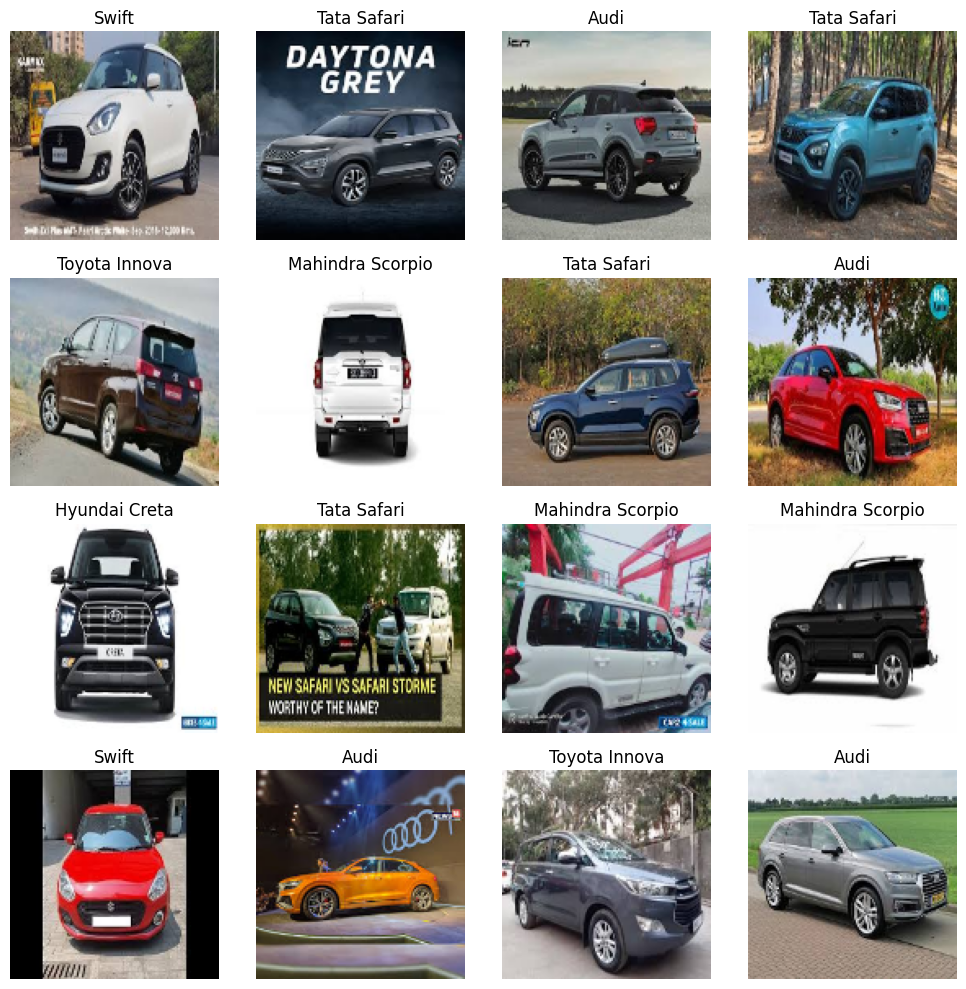

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def plot_images(images, labels, nrows=4, ncols=4):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    axes = axes.flatten()
    
    indices = np.random.choice(len(images), nrows * ncols, replace=False)
    
    for idx, ax in zip(indices, axes):
        img = images[idx]
        if img.dtype != np.uint8:
            img = (img * 255).astype('uint8')

        if img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        ax.set_title(labels[idx])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_images(train_images, train_labels, nrows=4, ncols=4)


In [12]:
# Normalizar las imágenes
train_images = train_images / 255.0
test_images = test_images / 255.0

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
train_labels_one_hot = to_categorical(train_labels_encoded)
test_labels_encoded = label_encoder.transform(test_labels)
test_labels_one_hot = to_categorical(test_labels_encoded)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam, Adamax

def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l1(0.0001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1(0.0001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        
        Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l1(0.0001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        
        Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l1(0.0001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        
        Conv2D(8, (3, 3), activation='relu', kernel_regularizer=l1(0.0001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        
        Flatten(),

        Dense(1024, activation='relu', kernel_regularizer=l1(0.0001)),
        Dropout(0.5),
        
        Dense(32, activation='relu', kernel_regularizer=l1(0.0001)),
        
        Dense(units=7, activation='softmax')
    ])
    
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [14]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical

def calculate_metrics(y_test, y_score, num_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    precision = dict()
    recall = dict()
    pr_auc = dict()

    y_test = label_binarize(y_test, classes=np.arange(num_classes))

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    return fpr, tpr, roc_auc, precision, recall, pr_auc

In [15]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0: 
            print(f"Epoch {epoch+1}: accuracy = {logs['accuracy']:.4f}, loss = {logs['loss']:.4f}, val_accuracy = {logs['val_accuracy']:.4f}, val_loss = {logs['val_loss']:.4f}")


In [16]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

X = train_images
y = np.argmax(train_labels_one_hot, axis=1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
num_classes = 7
accumulated_cm = np.zeros((7, 7), dtype=int) 

val_loss_history = []  
train_loss_history = []

val_accuracy_history = [] 
train_accuracy_history = []

all_fpr = []
all_tpr = []
all_precision = []
all_recall = []

metrics_results = {
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'auc': []
}


fold_no = 1
for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index] 
    
    y_train_fold_onehot = to_categorical(y_train_fold, num_classes=np.max(y)+1)
    y_test_fold_onehot = to_categorical(y_test_fold, num_classes=np.max(y)+1)


    model = build_model()

    print(f'Training for fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold_onehot, epochs=80, validation_data=(X_test_fold, y_test_fold_onehot), callbacks=[CustomCallback()], verbose=0)
    
    y_pred_prob = model.predict(X_test_fold)
    y_pred = np.argmax(y_pred_prob, axis=1)

    val_loss_history.append(history.history['val_loss'])
    train_loss_history.append(history.history['loss'])
    val_accuracy_history.append(history.history['val_accuracy'])  
    train_accuracy_history.append(history.history['accuracy']) 
    
    y_pred_prob = model.predict(X_test_fold)
    y_pred = np.argmax(y_pred_prob, axis=1)

    fpr, tpr, roc_auc, precision, recall, pr_auc = calculate_metrics(y_test_fold, y_pred_prob, num_classes)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_precision.append(precision)
    all_recall.append(recall)
    
    metrics_results['accuracy'].append(accuracy_score(y_test_fold, y_pred))
    metrics_results['recall'].append(recall_score(y_test_fold, y_pred, average='macro'))
    metrics_results['precision'].append(precision_score(y_test_fold, y_pred, average='macro'))
    metrics_results['f1'].append(f1_score(y_test_fold, y_pred, average='macro'))
    metrics_results['auc'].append(roc_auc_score(y_test_fold_onehot, y_pred_prob, multi_class='ovr'))

    
    cm = confusion_matrix(y_test_fold, y_pred)
    accumulated_cm += cm

    fold_no += 1

Training for fold 1...
Epoch 5: accuracy = 0.3551, loss = 2.0301, val_accuracy = 0.3185, val_loss = 2.1400
Epoch 10: accuracy = 0.4135, loss = 1.9074, val_accuracy = 0.4256, val_loss = 1.8740
Epoch 15: accuracy = 0.4688, loss = 1.7729, val_accuracy = 0.4643, val_loss = 1.8187
Epoch 20: accuracy = 0.4821, loss = 1.6765, val_accuracy = 0.4375, val_loss = 1.8788
Epoch 25: accuracy = 0.5179, loss = 1.6165, val_accuracy = 0.5298, val_loss = 1.6229
Epoch 30: accuracy = 0.5424, loss = 1.5544, val_accuracy = 0.4524, val_loss = 1.7027
Epoch 35: accuracy = 0.5507, loss = 1.5052, val_accuracy = 0.5060, val_loss = 1.5730
Epoch 40: accuracy = 0.5613, loss = 1.4354, val_accuracy = 0.5327, val_loss = 1.5045
Epoch 45: accuracy = 0.5700, loss = 1.4277, val_accuracy = 0.5357, val_loss = 1.4966
Epoch 50: accuracy = 0.5826, loss = 1.3819, val_accuracy = 0.5565, val_loss = 1.4658
Epoch 55: accuracy = 0.5908, loss = 1.3600, val_accuracy = 0.5714, val_loss = 1.4954
Epoch 60: accuracy = 0.5975, loss = 1.3393,

2024-04-30 06:53:28.995741: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15882: 6.22994, expected 5.50299
2024-04-30 06:53:28.995797: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15906: 5.99106, expected 5.2641
2024-04-30 06:53:28.995807: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15918: 6.20212, expected 5.47516
2024-04-30 06:53:28.995832: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15919: 5.7922, expected 5.06524
2024-04-30 06:53:28.995841: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15937: 5.3571, expected 4.63015
2024-04-30 06:53:28.995849: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15947: 6.08377, expected 5.35682
2024-04-30 06:53:28.995857: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15954: 6.20606, expected 5.47911
2024-04-30 06:53:28.995865: E 

Epoch 5: accuracy = 0.3563, loss = 2.0587, val_accuracy = 0.2627, val_loss = 2.2045
Epoch 10: accuracy = 0.3914, loss = 1.9403, val_accuracy = 0.4149, val_loss = 1.8911
Epoch 15: accuracy = 0.4335, loss = 1.8352, val_accuracy = 0.4090, val_loss = 1.8998
Epoch 20: accuracy = 0.4581, loss = 1.7502, val_accuracy = 0.4866, val_loss = 1.7379
Epoch 25: accuracy = 0.5078, loss = 1.6534, val_accuracy = 0.5045, val_loss = 1.6297
Epoch 30: accuracy = 0.5114, loss = 1.6131, val_accuracy = 0.5075, val_loss = 1.6598
Epoch 35: accuracy = 0.5244, loss = 1.5569, val_accuracy = 0.5493, val_loss = 1.4810
Epoch 40: accuracy = 0.5496, loss = 1.4949, val_accuracy = 0.5522, val_loss = 1.4801
Epoch 45: accuracy = 0.5688, loss = 1.4329, val_accuracy = 0.5582, val_loss = 1.4613
Epoch 50: accuracy = 0.5741, loss = 1.4178, val_accuracy = 0.5851, val_loss = 1.4088
Epoch 55: accuracy = 0.5827, loss = 1.3842, val_accuracy = 0.5970, val_loss = 1.3696
Epoch 60: accuracy = 0.5996, loss = 1.3355, val_accuracy = 0.5851,

In [17]:
print("Average Metrics Across All Folds:")
for metric, values in metrics_results.items():
    print(f"{metric}: {np.mean(values):.4f}")


Average Metrics Across All Folds:
accuracy: 0.6242
recall: 0.5341
precision: 0.6049
f1: 0.5146
auc: 0.9005


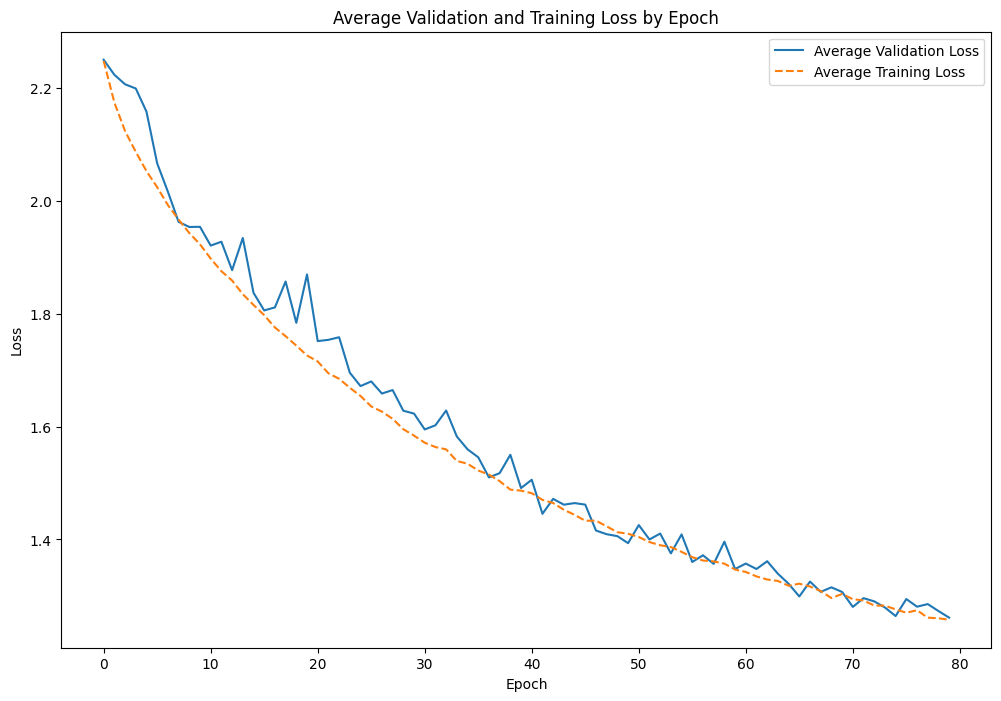

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(val_loss_history, train_loss_history):
    plt.figure(figsize=(12, 8))

    avg_val_loss = np.mean(val_loss_history, axis=0)
    avg_train_loss = np.mean(train_loss_history, axis=0)

    plt.plot(avg_val_loss, label='Average Validation Loss')
    plt.plot(avg_train_loss, label='Average Training Loss', linestyle='--')

    plt.title('Average Validation and Training Loss by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(val_loss_history, train_loss_history)


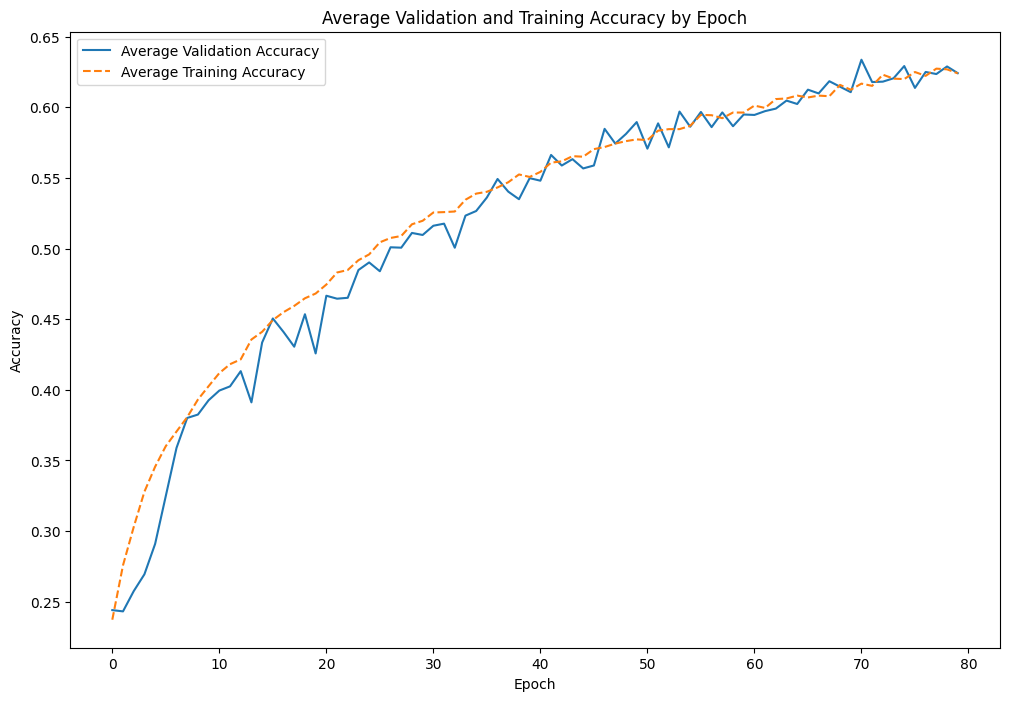

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy(val_accuracy_history, train_accuracy_history):
    plt.figure(figsize=(12, 8))

    avg_val_accuracy = np.mean(val_accuracy_history, axis=0)
    avg_train_accuracy = np.mean(train_accuracy_history, axis=0)

    plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
    plt.plot(avg_train_accuracy, label='Average Training Accuracy', linestyle='--')

    plt.title('Average Validation and Training Accuracy by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(val_accuracy_history, train_accuracy_history)


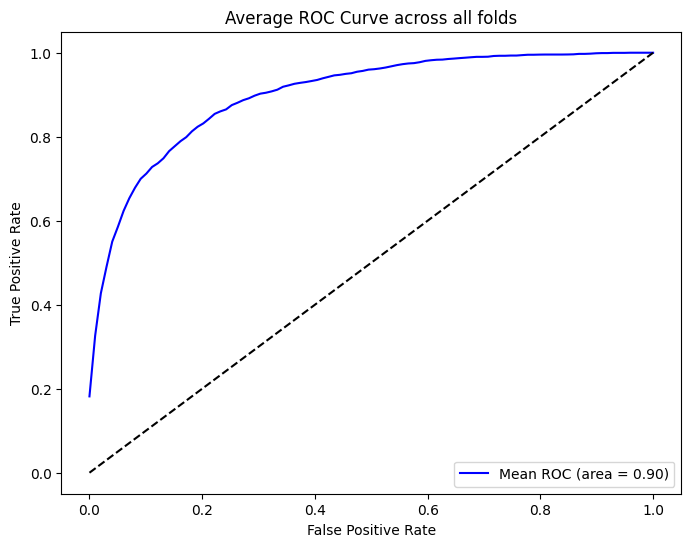

In [20]:
from scipy import interp
from numpy import linspace

def plot_average_roc(all_fpr, all_tpr, num_classes):
    mean_fpr = linspace(0, 1, 100)
    
    mean_tpr = np.zeros_like(mean_fpr)
    for fpr, tpr in zip(all_fpr, all_tpr):
        for i in range(num_classes):
            mean_tpr += interp(mean_fpr, fpr[i], tpr[i])
    
    mean_tpr /= (len(all_fpr) * num_classes)
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=f'Mean ROC (area = {auc(mean_fpr, mean_tpr):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across all folds')
    plt.legend(loc='lower right')
    plt.show()

plot_average_roc(all_fpr, all_tpr, num_classes)

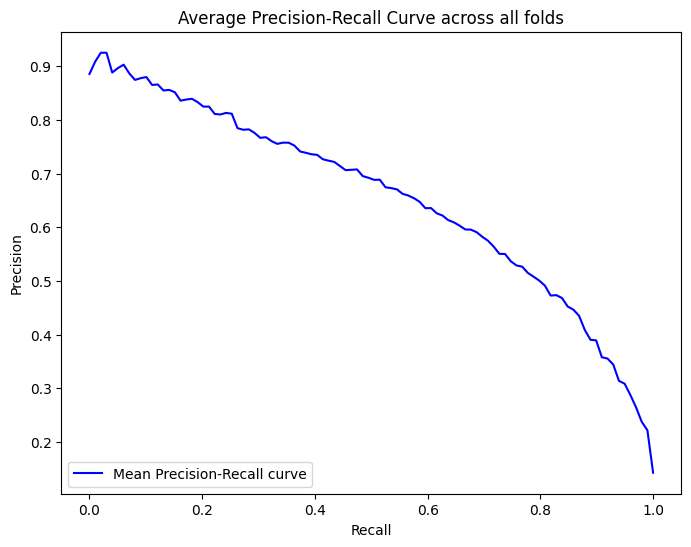

In [21]:
def plot_average_precision_recall(all_precision, all_recall, num_classes):
    mean_recall = linspace(0, 1, 100)
    
    mean_precision = np.zeros_like(mean_recall)
    for precision, recall in zip(all_precision, all_recall):
        for i in range(num_classes):
            mean_precision += interp(mean_recall, recall[i][::-1], precision[i][::-1])
    

    mean_precision /= (len(all_precision) * num_classes)
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_recall, mean_precision, color='blue',
             label='Mean Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average Precision-Recall Curve across all folds')
    plt.legend(loc='lower left')
    plt.show()

plot_average_precision_recall(all_precision, all_recall, num_classes)


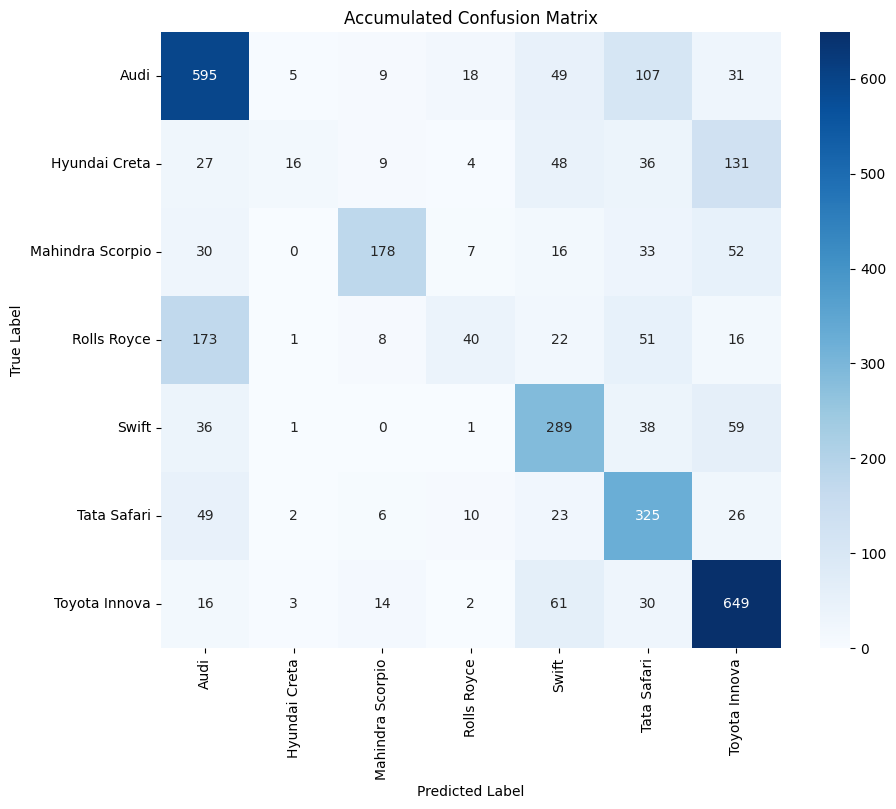

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('Accumulated Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

class_names = ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']
plot_confusion_matrix(accumulated_cm, class_names)


In [23]:
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)


14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

2024-04-30 07:09:26.050498: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 179: 5.28614, expected 4.64663
2024-04-30 07:09:26.050562: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 450: 5.0653, expected 4.4258
2024-04-30 07:09:26.050572: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 549: 5.06694, expected 4.42744
2024-04-30 07:09:26.050581: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 550: 5.34534, expected 4.70584
2024-04-30 07:09:26.050588: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 551: 5.35632, expected 4.71682
2024-04-30 07:09:26.050596: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 552: 5.34166, expected 4.70216
2024-04-30 07:09:26.050604: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 590: 5.28539, expected 4.64588
2024-04-30 07:09:26.050612: E external/loca

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


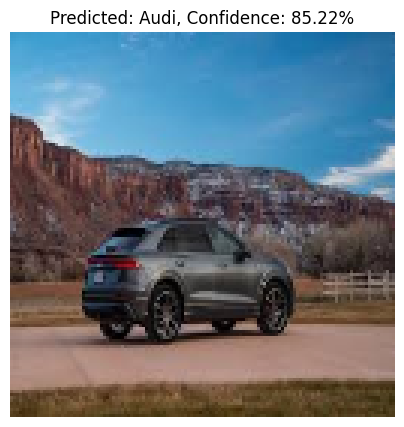

Predictions for each class:
Audi: 85.22%
Hyundai Creta: 0.46%
Mahindra Scorpio: 0.12%
Rolls Royce: 6.31%
Swift: 0.17%
Tata Safari: 7.02%
Toyota Innova: 0.71%




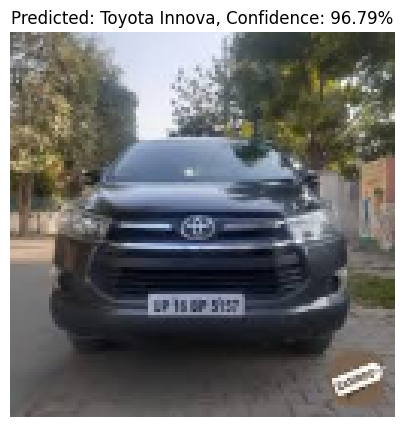

Predictions for each class:
Audi: 0.31%
Hyundai Creta: 2.07%
Mahindra Scorpio: 0.14%
Rolls Royce: 0.10%
Swift: 0.32%
Tata Safari: 0.28%
Toyota Innova: 96.79%




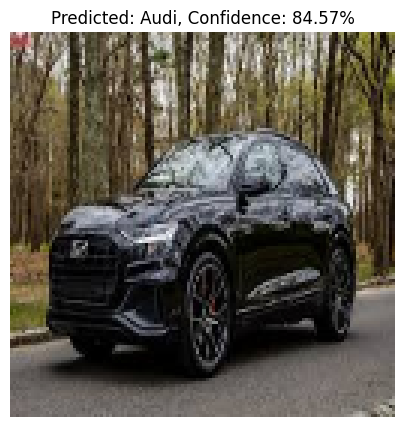

Predictions for each class:
Audi: 84.57%
Hyundai Creta: 0.37%
Mahindra Scorpio: 0.47%
Rolls Royce: 12.07%
Swift: 0.18%
Tata Safari: 2.26%
Toyota Innova: 0.07%




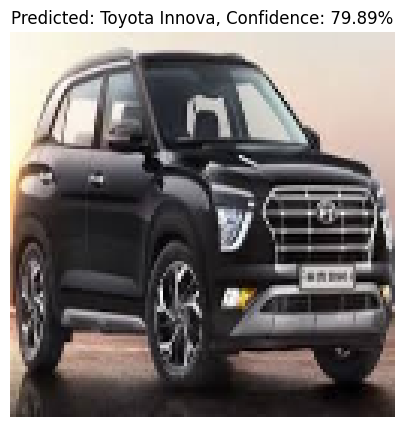

Predictions for each class:
Audi: 0.54%
Hyundai Creta: 17.53%
Mahindra Scorpio: 0.12%
Rolls Royce: 0.04%
Swift: 1.66%
Tata Safari: 0.21%
Toyota Innova: 79.89%




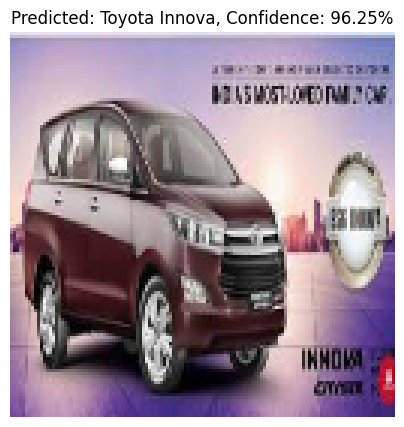

Predictions for each class:
Audi: 0.07%
Hyundai Creta: 2.21%
Mahindra Scorpio: 0.21%
Rolls Royce: 0.08%
Swift: 1.05%
Tata Safari: 0.13%
Toyota Innova: 96.25%




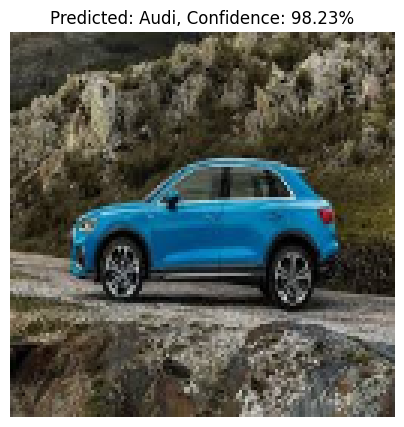

Predictions for each class:
Audi: 98.23%
Hyundai Creta: 0.14%
Mahindra Scorpio: 0.01%
Rolls Royce: 1.09%
Swift: 0.23%
Tata Safari: 0.27%
Toyota Innova: 0.02%




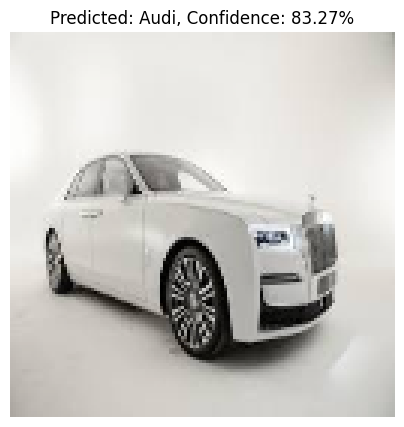

Predictions for each class:
Audi: 83.27%
Hyundai Creta: 0.66%
Mahindra Scorpio: 0.13%
Rolls Royce: 7.13%
Swift: 2.27%
Tata Safari: 6.19%
Toyota Innova: 0.36%




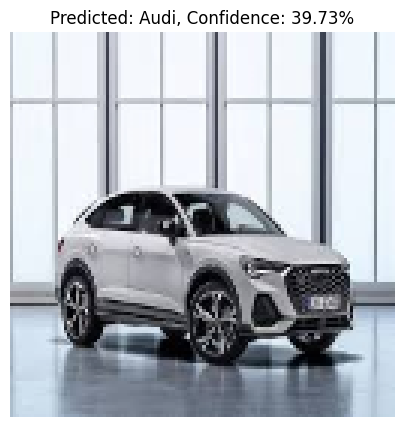

Predictions for each class:
Audi: 39.73%
Hyundai Creta: 1.99%
Mahindra Scorpio: 0.46%
Rolls Royce: 7.29%
Swift: 14.26%
Tata Safari: 35.21%
Toyota Innova: 1.06%




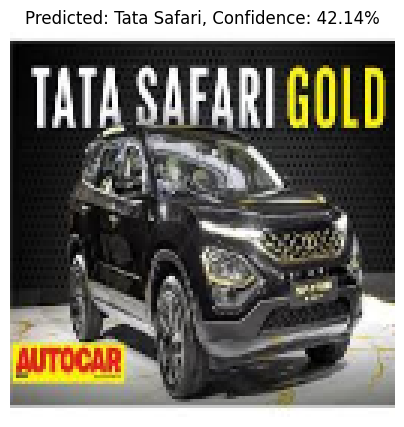

Predictions for each class:
Audi: 22.62%
Hyundai Creta: 5.51%
Mahindra Scorpio: 2.34%
Rolls Royce: 6.72%
Swift: 18.14%
Tata Safari: 42.14%
Toyota Innova: 2.54%




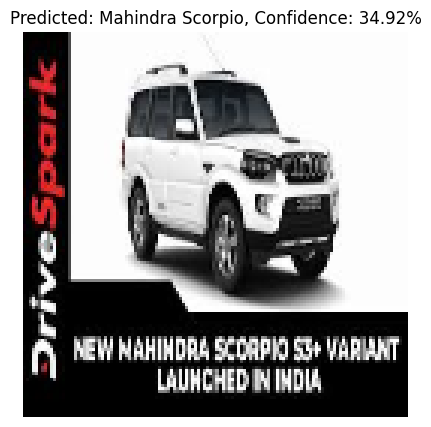

Predictions for each class:
Audi: 3.00%
Hyundai Creta: 13.35%
Mahindra Scorpio: 34.92%
Rolls Royce: 4.95%
Swift: 11.72%
Tata Safari: 27.55%
Toyota Innova: 4.51%




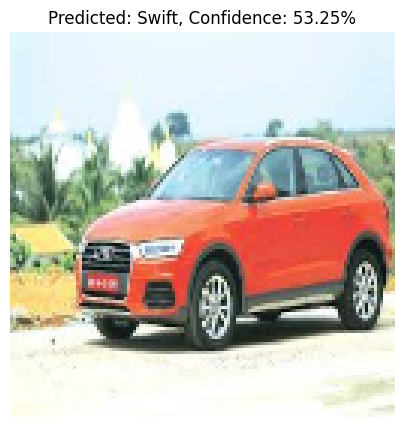

Predictions for each class:
Audi: 26.22%
Hyundai Creta: 6.78%
Mahindra Scorpio: 0.17%
Rolls Royce: 4.28%
Swift: 53.25%
Tata Safari: 6.59%
Toyota Innova: 2.71%




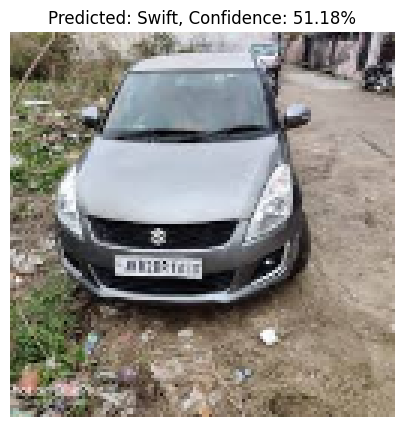

Predictions for each class:
Audi: 1.56%
Hyundai Creta: 14.68%
Mahindra Scorpio: 0.51%
Rolls Royce: 0.43%
Swift: 51.18%
Tata Safari: 0.42%
Toyota Innova: 31.23%




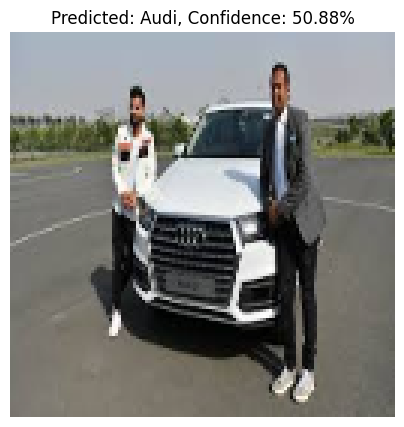

Predictions for each class:
Audi: 50.88%
Hyundai Creta: 8.19%
Mahindra Scorpio: 4.91%
Rolls Royce: 6.17%
Swift: 1.95%
Tata Safari: 12.73%
Toyota Innova: 15.18%




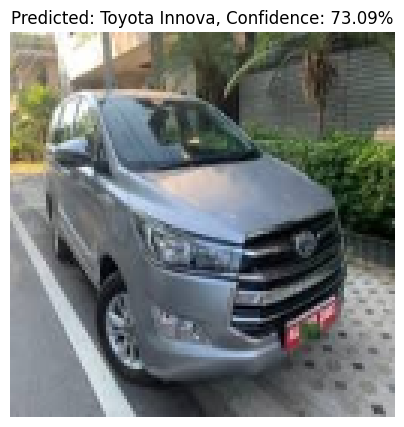

Predictions for each class:
Audi: 4.04%
Hyundai Creta: 11.09%
Mahindra Scorpio: 1.90%
Rolls Royce: 1.38%
Swift: 6.90%
Tata Safari: 1.60%
Toyota Innova: 73.09%




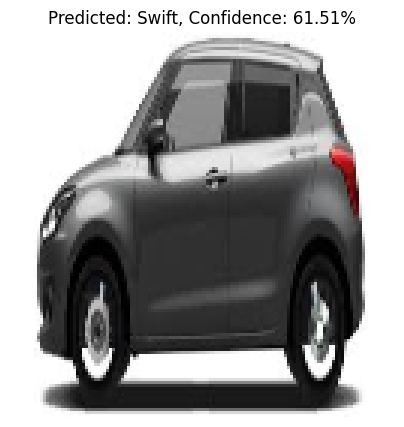

Predictions for each class:
Audi: 1.83%
Hyundai Creta: 7.14%
Mahindra Scorpio: 1.39%
Rolls Royce: 1.11%
Swift: 61.51%
Tata Safari: 3.87%
Toyota Innova: 23.14%




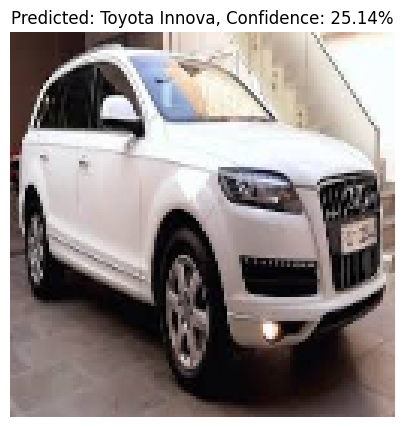

Predictions for each class:
Audi: 21.20%
Hyundai Creta: 20.20%
Mahindra Scorpio: 0.65%
Rolls Royce: 15.72%
Swift: 13.47%
Tata Safari: 3.61%
Toyota Innova: 25.14%




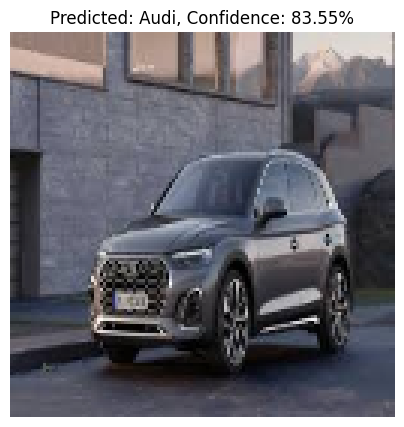

Predictions for each class:
Audi: 83.55%
Hyundai Creta: 0.42%
Mahindra Scorpio: 0.16%
Rolls Royce: 6.73%
Swift: 1.07%
Tata Safari: 7.84%
Toyota Innova: 0.23%




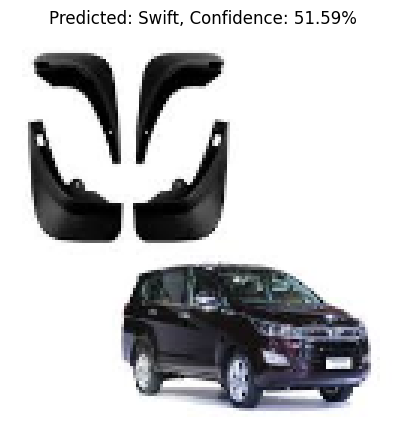

Predictions for each class:
Audi: 8.49%
Hyundai Creta: 10.24%
Mahindra Scorpio: 0.49%
Rolls Royce: 4.92%
Swift: 51.59%
Tata Safari: 9.04%
Toyota Innova: 15.23%




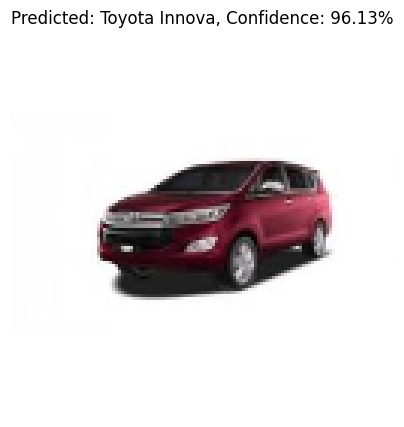

Predictions for each class:
Audi: 0.23%
Hyundai Creta: 1.90%
Mahindra Scorpio: 0.39%
Rolls Royce: 0.32%
Swift: 0.88%
Tata Safari: 0.16%
Toyota Innova: 96.13%




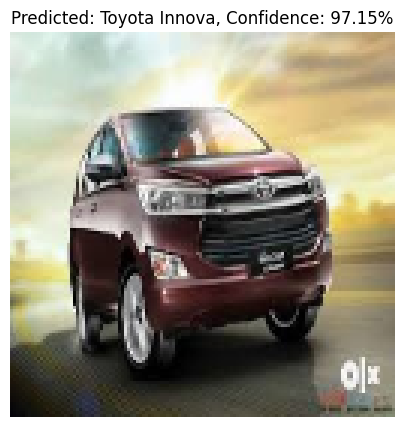

Predictions for each class:
Audi: 0.08%
Hyundai Creta: 2.53%
Mahindra Scorpio: 0.08%
Rolls Royce: 0.09%
Swift: 0.02%
Tata Safari: 0.05%
Toyota Innova: 97.15%




In [24]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def plot_predictions(images, labels, predictions, label_encoder, num_images_to_show=30):
    num_images_to_show = min(num_images_to_show, len(images))
    
    indices = np.random.choice(len(images), num_images_to_show, replace=False)
    
    for idx in indices:
        img = images[idx].copy()
        if img.dtype != np.uint8:
            img = (img * 255).astype('uint8')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

        pred_label = label_encoder.inverse_transform([labels[idx]])[0]
        confidence = np.max(predictions[idx])

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Predicted: {pred_label}, Confidence: {confidence*100:.2f}%")
        plt.axis('off')
        plt.show()

        class_predictions = predictions[idx]
        print("Predictions for each class:")
        for i, conf in enumerate(class_predictions):
            class_name = label_encoder.inverse_transform([i])[0]
            print(f"{class_name}: {conf*100:.2f}%")
        print("\n") 

plot_predictions(test_images, predicted_classes, predictions, label_encoder, num_images_to_show=20)
